In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,LabelBinarizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support,f1_score
from sklearn.metrics import classification_report
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from pandas.tools.plotting import parallel_coordinates
from math import pi

In [2]:
wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)
import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

In [3]:
wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset
    
wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)
wine_base = OneHotEncode(wine_base,"country")
wine_base = wine_base.drop('country', 1)
#wine_base["variety"] = wine_base["variety"].astype('category').cat.codes


10.0


<module 'seaborn' from 'E:\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>

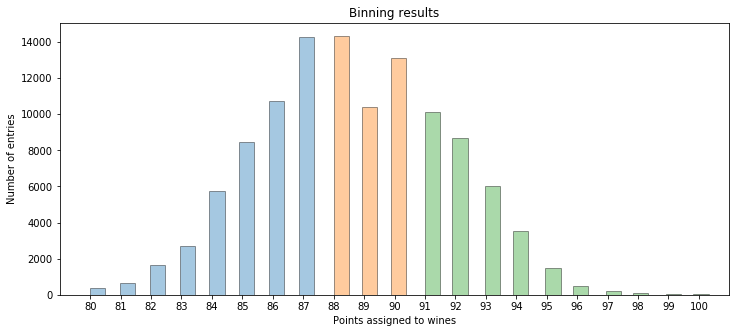

In [4]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  

#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
plt.ylabel("Number of entries")
plt.xlabel("Points assigned to wines")
plt.title("Binning results")
print(g)
sns

In [69]:
#create a dataframe with every test combination you put
def testToDataFrame(algorithm,combination,Y,allfeats,dataset):
    test_size = 0.30 
    cols = ["algorithm","input","precision","accuracy","f1","depth"]
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeats: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    row = 0
    comb = 0
    for el in combination["args"]: 
        for depth in combination["depth"]:
            row = row + 1
            X = dataset.loc[:,el]
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
            if algorithm == "decTree":
                classifier = DecisionTreeClassifier(max_depth=depth)
            else:
                classifier = RandomForestClassifier(max_depth=depth,n_estimators = estimators)
            y_train = list(y_train)
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)  
            acc = accuracy_score(y_test,y_pred)
            weightedPrec = precision_score(y_test,y_pred,average="weighted") 
            f1 = f1_score(y_test,y_pred,average="weighted")
            data = [algorithm,el,weightedPrec,acc,f1,depth]
            precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
            for i in range(0,len(labels)):
                data.append(precision[i])
                data.append(recall[i])
                data.append(fscore[i])
                data.append(support[i])
            #for lab in labels:
            
             #   data.append(rep[lab].precision)     #ORDER IS VERY IMPORTANT
              #  data.append(rep[lab].recall)
               # data.append(rep[lab].f1-score)
                #data.append(rep[lab].support)
            temp = {}
            c = zip(el,classifier.feature_importances_)
            counter = 0
            names = []
            for name,importance in c:
                    temp[name] = importance
                    names.append(name)
            for feat in names:
                    data.append(temp[feat])
            df2 = pd.DataFrame([data],columns=cols)
            results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results,classifier

In [104]:
data = wine_base.drop(["points","description","region_1","winery","variety","designation"],axis=1)
args = data.columns.tolist()
allfeatures = args
decTreeCombinations = {"depth":[2,3,4,5,6,7,8,9],"args":[args]}
res = pd.DataFrame()
res,clf = testToDataFrame("decTree",decTreeCombinations,Y,allfeatures,data)

In [105]:
len(res.columns)

289

In [106]:
res = res.loc[:, (res != 0).any(axis=0)]
res = res.sort_values(["f1"],ascending=False)
res

,algorithm,input,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Tuscany,feat_Veneto,feat_Virginia,feat_Washington,feat_Wiener Gemischter Satz,feat_Österreichischer Sekt,feat_Australia,feat_France,feat_Italy,feat_US
7,decTree,"[price, similarityTop3WinesByVariety, word_cou...",0.626919,0.626361,0.626167,9,0.682184,0.625638,0.652689,9205,...,0.001247,0.000482,0.000591,0.000608,0.000113,0.000379,0.000137,0.000109,0.006797,0.006159
6,decTree,"[price, similarityTop3WinesByVariety, word_cou...",0.624603,0.622713,0.623149,8,0.679637,0.618577,0.647671,9205,...,0.001156,0.000000,0.000624,0.000350,0.000120,0.000518,0.000000,0.000119,0.003993,0.005583
5,decTree,"[price, similarityTop3WinesByVariety, word_cou...",0.616201,0.616976,0.615755,7,0.676765,0.609125,0.641166,9205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000424,0.000000,0.000000,0.003321,0.003522
4,decTree,"[price, similarityTop3WinesByVariety, word_cou...",0.600999,0.609620,0.603421,6,0.620606,0.698207,0.657124,9205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000448,0.000000,0.000000,0.000000,0.002947
3,decTree,"[price, similarityTop3WinesByVariety, word_cou...",0.607093,0.599382,0.602206,5,0.662727,0.590875,0.624742,9205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001938
2,decTree,"[price, similarityTop3WinesByVariety, word_cou...",0.596212,0.593822,0.594830,4,0.634216,0.600869,0.617092,9205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,decTree,"[price, similarityTop3WinesByVariety, word_cou...",0.588211,0.577699,0.578444,3,0.582029,0.719174,0.643374,9205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,decTree,"[price, similarityTop3WinesByVariety, word_cou...",0.532110,0.543572,0.527323,2,0.637473,0.505269,0.563723,9205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


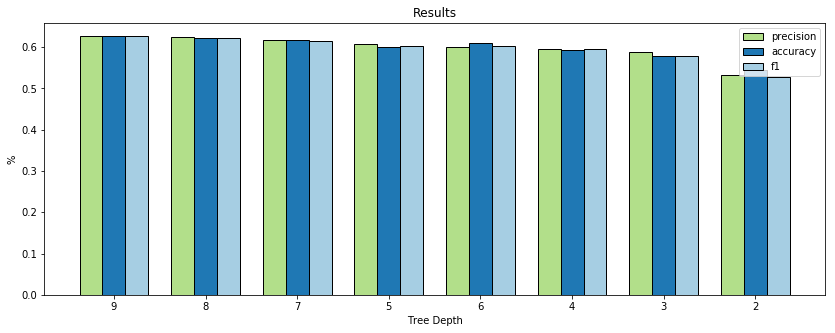

In [85]:
#plot f1 by category predicted 
barWidth = 0.25
temp = pd.DataFrame()
temp = res
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["depth"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results")
plt.ylabel('%')
plt.xlabel("Tree Depth")
plt.legend()
 
# Show graphic
plt.show()


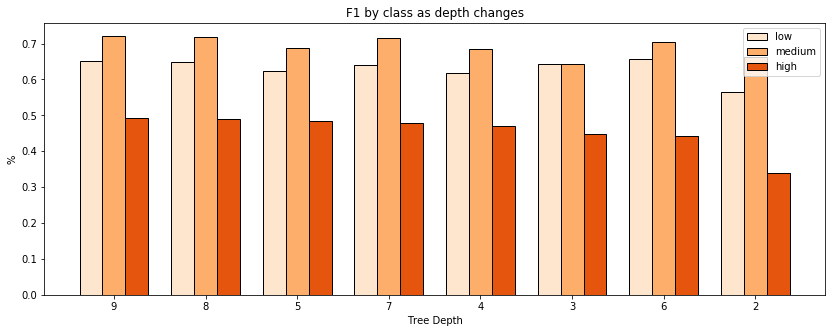

In [87]:
#plot f1 by category predicted 
temp = pd.DataFrame()
temp = res
temp = temp.sort_values(["high_f1","low_f1"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_f1"]
# Choose the height of the cyan bars
bars2 = temp["medium_f1"]

bars3 = temp["high_f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["depth"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Tree Depth")
plt.legend()
plt.title("F1 by class as depth changes") 
# Show graphic
plt.show()

Depth of 3/4 is fine and keeps it readable

In [ ]:
#show me the tree
##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed

import os
import sys
import pydotplus 
from sklearn import tree
from IPython.display import Image  

def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)
    
dot_data = tree.export_graphviz(clf, out_file=None,   
                             class_names=labels,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

In [96]:
features = []
for col in temp.columns:
    if col.startswith("feat") or col == "depth":
        features.append(col)
print(features)

t1 = pd.DataFrame()
for col in features: 
    t1[col] = temp[col]
t1.reset_index(inplace=True,drop=True)
t1

['depth', 'feat_price', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anne Krebiehl\xa0MW', 'feat_Carrie Dykes', 'feat_Jim Gordon', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_Sean P. Sullivan', 'feat_Susan Kostrzewa', 'feat_Virginie Boone', 'feat_unknown', 'feat_Alsace', 'feat_Austria', 'feat_Beaujolais', 'feat_Bordeaux', 'feat_Burgenland', 'feat_Burgundy', 'feat_California', 'feat_Carnuntum', 'feat_Catalonia', 'feat_Chile', 'feat_Douro', 'feat_Dão', 'feat_Galicia', 'feat_Germany', 'feat_Idaho', 'feat_Kamptal', 'feat_Kremstal', 'feat_Leyda Valley', 'feat_Limarí Valley', 'feat_Maipo Valley', 'feat_Marlborough', 'feat_Michigan', 'feat_New York', 'feat_Niederösterreich', 'feat_Northeastern Italy', 'feat_Northern Spain', 'feat_Pfalz', 'feat_Piedmont', 'feat_Portugal', 'feat_Provence', 'feat_Sicily & Sardinia', 'feat_South Africa', 'feat_South Australia', 'fea

,depth,feat_price,feat_similarityTop3WinesByVariety,feat_word_count,feat_vintage,feat_Alexander Peartree,feat_Anne Krebiehl MW,feat_Carrie Dykes,feat_Jim Gordon,feat_Joe Czerwinski,...,feat_Veneto,feat_Virginia,feat_Wagram-Donauland,feat_Washington,feat_Western Australia,feat_Wiener Gemischter Satz,feat_Österreichischer Sekt,feat_France,feat_Italy,feat_US
0,9,0.591107,0.076588,0.166034,0.019001,0.001514,0.015991,0.000324,0.001247,0.001351,...,0.000482,0.000591,0.000094,0.000608,0.000110,0.000113,0.000488,0.000112,0.005256,0.006159
1,8,0.619858,0.062904,0.169406,0.015017,0.000472,0.015783,0.000000,0.001109,0.000366,...,0.000000,0.000624,0.000000,0.000350,0.000117,0.000120,0.000518,0.000365,0.003993,0.005583
2,5,0.704657,0.036764,0.167934,0.000000,0.000000,0.009861,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001938
3,7,0.647951,0.053956,0.169285,0.010053,0.000625,0.016138,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000424,0.000000,0.004025,0.003522
4,4,0.757119,0.010788,0.151034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,3,0.849701,0.000000,0.150299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,0.670428,0.050073,0.168820,0.007264,0.000000,0.017060,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000448,0.000000,0.000000,0.002947
7,2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


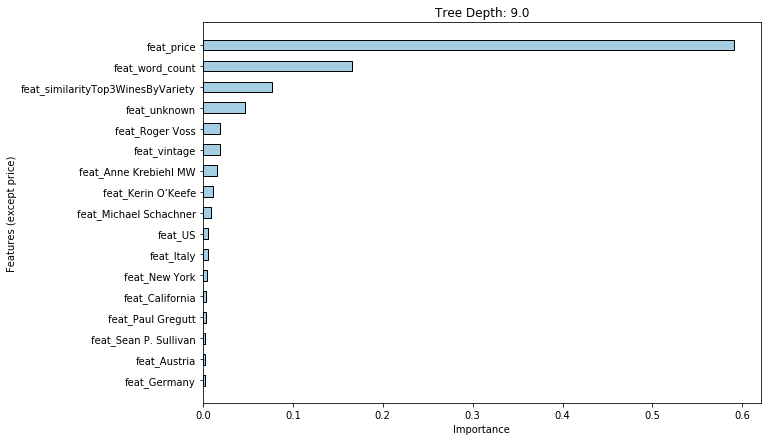

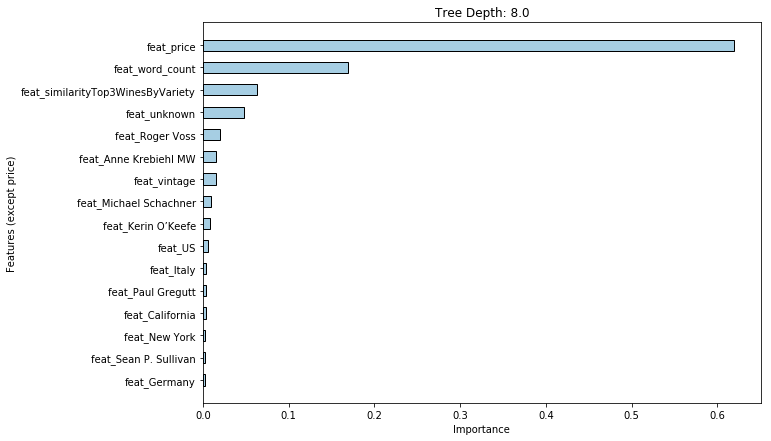

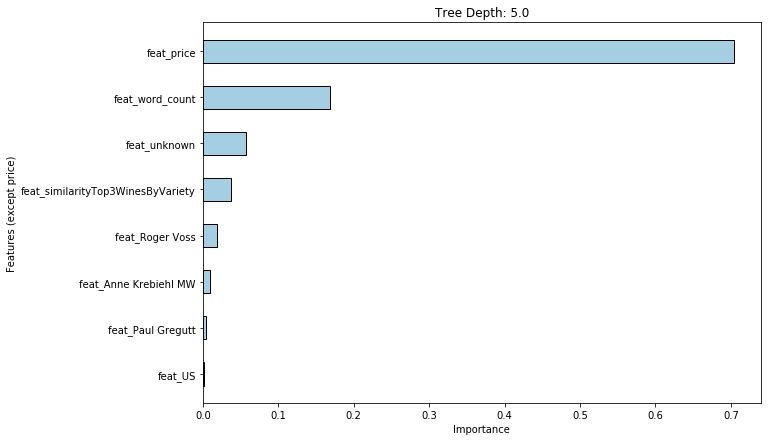

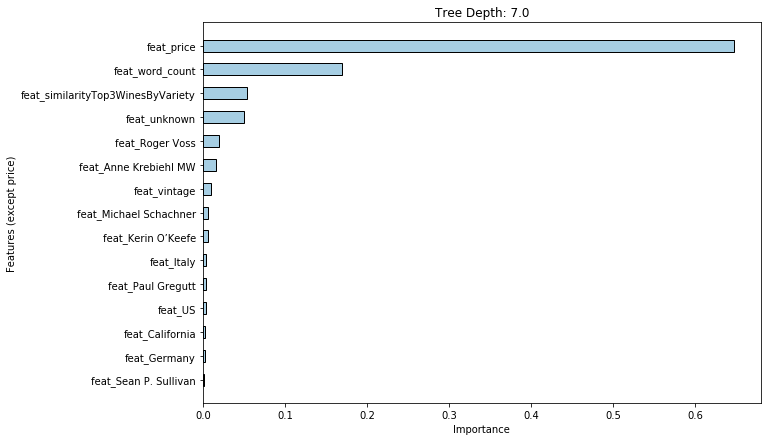

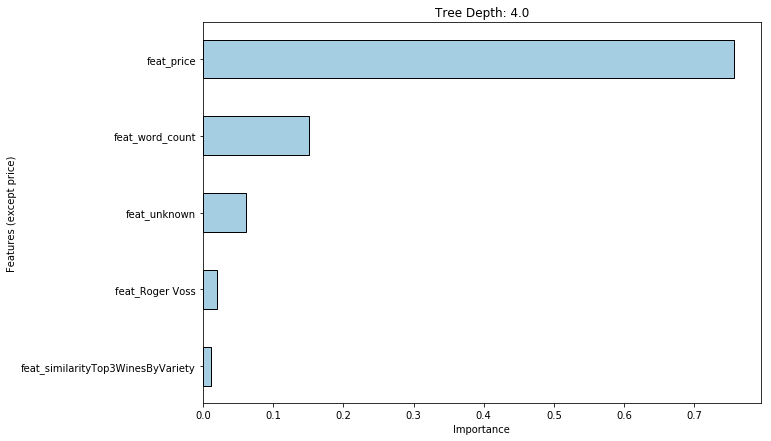

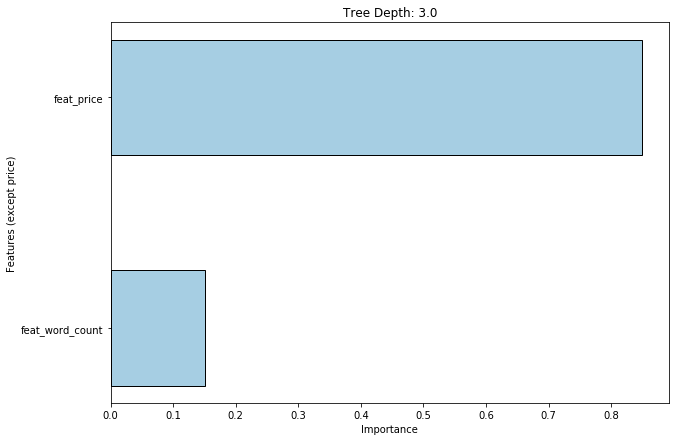

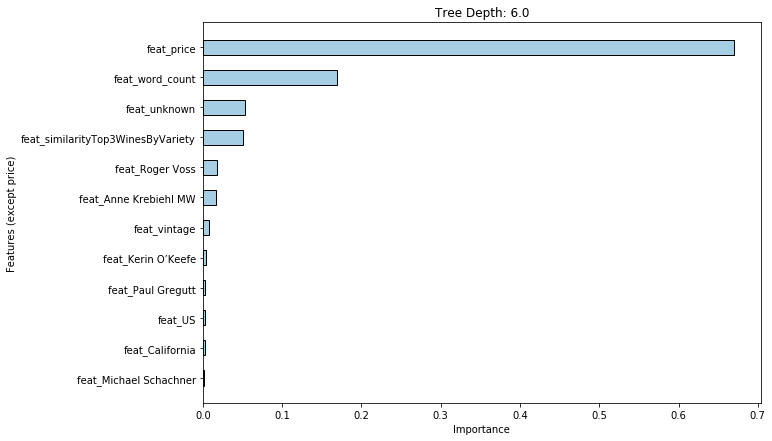

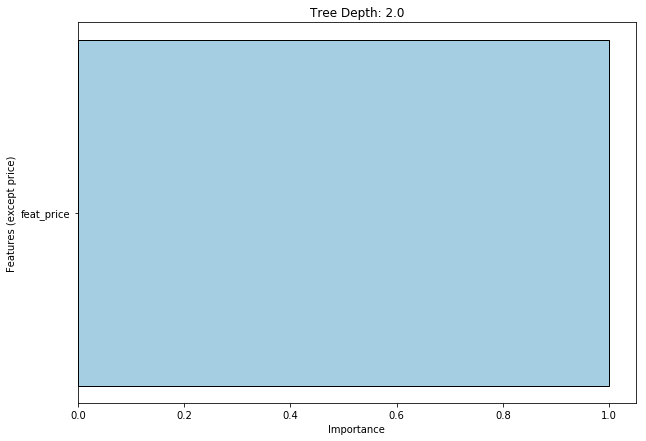

In [108]:
for idx,row in t1.iterrows():
    both = []
    for col in t1.columns:
        if row[col] != 0 and col != "depth":    #ignore price
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    
    toPlot = []
    values = []    
    for el in both:
        if (el[1] > 0.001591):
            toPlot.append(el[0])
            values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Tree Depth: " + str(row["depth"]))
    plt.ylabel('Features (except price)')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

In generale, osservando tutte le varie depth, si può dire che price la fa da padrone, seguito da word count e dalla similarità calcolata sul word2vec, anche variando la depth